In [42]:
# Kaggle titanic survival challenge
# https://www.kaggle.com/c/titanic
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

titanic = pd.read_csv("datasets/titanic/train.csv")

rename = {
    "PassengerId": "passenger_id",
    "Survived": "survived",
    "Pclass": "ticket_class", # ticket class 1 / 2 / 3
    "Name": "name",
    "Sex": "sex",
    "Age": "age",
    "SibSp": "sibling_spouse", # number of siblings / spouses on board
    "Parch": "children_parents", # number of children / parents on board
    "Ticket": "ticket", # ticket number
    "Fare": "fare",
    "Cabin": "cabin",
    "Embarked": "embarked", # Port of embarkation
}

titanic = titanic.rename(columns=rename)

X_test = titanic.drop("survived", axis=1)
y_test = titanic["survived"]

In [43]:
X_test.info()
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   passenger_id      891 non-null    int64  
 1   ticket_class      891 non-null    int64  
 2   name              891 non-null    object 
 3   sex               891 non-null    object 
 4   age               714 non-null    float64
 5   sibling_spouse    891 non-null    int64  
 6   children_parents  891 non-null    int64  
 7   ticket            891 non-null    object 
 8   fare              891 non-null    float64
 9   cabin             204 non-null    object 
 10  embarked          889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   passenger_id     

Text(0, 0.5, 'Fare')

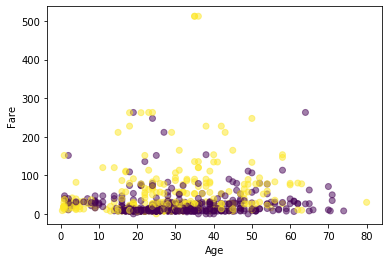

In [44]:
%matplotlib inline

plt.scatter(titanic["age"], titanic["fare"], alpha=0.5, c=titanic["survived"], cmap='viridis')
plt.xlabel("Age")
plt.ylabel("Fare")

# The higher fares definitely gave a big boost to survival

In [83]:
# Prep cabin, embarked, sex
# Transform name to some kind of surname based columns
# May be beneficial to set some rules around cabin to get something more useful like location on ship (how deep / how wide out etc)

# Standardize the data prior to any training

# First letter of cabin is the floor - important.
from sklearn.base import BaseEstimator, TransformerMixin
import re

class PrepareCategoryData(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def _set_up_title(self, df):
        # Took influence from google for titles, didn't consider it myself, thought perhaps surnames would
        # help but this makes a lot more sense
        titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royalty": 5}
        df['title'] = df["name"].str.extract(' ([A-Za-z]+)\.', expand=False)
        df['title'] = df['title'].replace(
            ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
            'Royalty'
        )
        df['title'] = df['title'].replace('Mlle', 'Miss')
        df['title'] = df['title'].replace('Ms', 'Miss')
        df['title'] = df['title'].replace('Mme', 'Mrs')
        df['title'] = df['title'].map(titles)
        df['title'] = df['title'].fillna(0)
        return df['title']

    def _set_up_floor(self, df):
        # Prior to this, attempting to use OneHotEncoder on just the letters didn't work as well
        # Probably as there is a numerical relation between the floors
        floor = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "Z": 8, "T": 0}
        df['floor'] = df['cabin'].astype(str).str[0]
        df['floor'] = df['floor'].map(floor)
        df['floor'] = df['floor'].astype(int)
        return df['floor']

    def transform(self, df):
        df['title'] = self._set_up_title(df)
        df['cabin'].fillna("Z0", inplace=True)
        df['floor'] = self._set_up_floor(df)
        df['embarked'].fillna("S", inplace=True)
        relatives = df['sibling_spouse'] + df['children_parents']
        df.drop(labels=['cabin', 'name', 'ticket', 'children_parents', 'sibling_spouse'], axis=1, inplace=True)
        return np.c_[df, relatives]

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

cat_encoder = OneHotEncoder()

num_attributes = ['age', 'fare']
cat_attributes = ['sex', 'cabin', 'embarked', 'name', 'ticket', 'children_parents', 'sibling_spouse']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

titanic_cat_pipeline = Pipeline([
    ('prep_cat_data', PrepareCategoryData()),
    ('cat_encoder', OneHotEncoder()),
])

full_pipeline = ColumnTransformer([
    ("cat", titanic_cat_pipeline, cat_attributes),
    ("num", num_pipeline, num_attributes),
])

X_titanic = titanic.copy()
y_titanic = X_titanic["survived"]
X_titanic.drop(labels=["survived"], axis=1, inplace=True)

titanic_prepared = full_pipeline.fit_transform(X_titanic)

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

r_forest_params = [
    {'n_estimators': [38, 40, 42], 'max_features': [10, 11, 12, 13], 'min_samples_leaf': [1, 2, 4, 6]}
]
r_forest = RandomForestClassifier()


grid_search = GridSearchCV(r_forest, r_forest_params, cv=5)
grid_search.fit(titanic_prepared, y_titanic)
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
print(grid_search.best_params_)

0.7901198920343984 {'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 38}
0.7844893603665808 {'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 40}
0.7878664239532986 {'max_features': 10, 'min_samples_leaf': 1, 'n_estimators': 42}
0.8181595631159375 {'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 38}
0.8181658401858012 {'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 40}
0.8103195028560668 {'max_features': 10, 'min_samples_leaf': 2, 'n_estimators': 42}
0.8069361621994853 {'max_features': 10, 'min_samples_leaf': 4, 'n_estimators': 38}
0.8091770761408574 {'max_features': 10, 'min_samples_leaf': 4, 'n_estimators': 40}
0.809189630280585 {'max_features': 10, 'min_samples_leaf': 4, 'n_estimators': 42}
0.8114179900822295 {'max_features': 10, 'min_samples_leaf': 6, 'n_estimators': 38}
0.8114305442219573 {'max_features': 10, 'min_samples_leaf': 6, 'n_estimators': 40}
0.8192894356914191 {'max_features': 10, 'min_samples_leaf': 6, 'n_estimators': 42}
0.800

In [90]:
svm_clf = SVC()

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1, 10]
svm_params = {'C': Cs, 'gamma' : gammas}

svm_clf.fit(titanic_prepared, y_titanic)
cross_val_score(svm_clf, titanic_prepared, y_titanic)

grid_search = GridSearchCV(svm_clf, svm_params, cv=5)
grid_search.fit(titanic_prepared, y_titanic)
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
print(grid_search.best_params_)

0.6161634548992531 {'C': 0.001, 'gamma': 0.001}
0.6161634548992531 {'C': 0.001, 'gamma': 0.01}
0.6161634548992531 {'C': 0.001, 'gamma': 0.1}
0.6161634548992531 {'C': 0.001, 'gamma': 1}
0.6161634548992531 {'C': 0.001, 'gamma': 10}
0.6161634548992531 {'C': 0.01, 'gamma': 0.001}
0.6161634548992531 {'C': 0.01, 'gamma': 0.01}
0.6161634548992531 {'C': 0.01, 'gamma': 0.1}
0.6161634548992531 {'C': 0.01, 'gamma': 1}
0.6161634548992531 {'C': 0.01, 'gamma': 10}
0.6161634548992531 {'C': 0.1, 'gamma': 0.001}
0.7014813884878539 {'C': 0.1, 'gamma': 0.01}
0.7934655702717971 {'C': 0.1, 'gamma': 0.1}
0.7576172242797062 {'C': 0.1, 'gamma': 1}
0.6217814324273429 {'C': 0.1, 'gamma': 10}
0.7172054484966418 {'C': 1, 'gamma': 0.001}
0.7889837423890528 {'C': 1, 'gamma': 0.01}
0.8248885820099178 {'C': 1, 'gamma': 0.1}
0.8058313979034587 {'C': 1, 'gamma': 1}
0.7418931642709183 {'C': 1, 'gamma': 10}
0.7867365513778168 {'C': 10, 'gamma': 0.001}
0.8305002824681438 {'C': 10, 'gamma': 0.01}
0.821542903772519 {'C': 10

In [91]:
titanic_test = pd.read_csv("datasets/titanic/test.csv")
titanic_test = titanic_test.rename(columns=rename)

actual_test = titanic_test.copy()

prepared_test = full_pipeline.transform(actual_test)

predictions = grid_search.best_estimator_.predict(prepared_test)

result = pd.DataFrame({'PassengerId': actual_test["passenger_id"], 'Survived': predictions})
result.to_csv("datasets/results/titanic-results.csv", index=False)

# SVC is working best with a score of 78.94%
# First score prior to adding titles from google & refactoring away from OneHotEncoder for floors and instead
# storing them numerically, we hit 71%

# All scores on test set on kaggle.